## **Title**

**Introduction**

   In this project, the data set that we were using was from a research group in Computer Science at UBC, led by Frank Wood. They collected the data through a MineCraft server where player’s actions were recorded. They needed to know what “kind” of players are most likely to contribute the most in order to make sure they have enough resources to target those players in their recruiting efforts. Therefore, the question we are trying to answer is “Can experience and age predict the played hours in the player dataset?”. The data set that we used to answer the question was players.csv. In this dataset, there are 196 observations and 7 variables. In those 7 variables, there were 2 quantitative variables and 5 categorical variables. The 2 quantitative variables are “played_hours” and “Age”. “played_hours” told us the number of hours each player spent playing the game. “Age” represented the age of each player. The 5 categorical variables are “hashedEmail”, “name”, “experience”, “Subscribe”, and “Gender”. “hashedEmail” is the email of each player. “name” showed us the name of the players. “experience” indicated the experience of the players (Beginner, Amateur, Veteran or Pro). “Subscribe” told us whether or not the players were subscribing to a game-related newsletter (TRUE/FALSE). “Gender” told us the gender of the players (female/male/non-binary/two-spirited/prefer not to say). In order to answer our question, we focused on using the variables “experience” and “Age” to help us predict the “played_hours” as we believed that whichever type of player have the highest played hours would contribute the most.

In [2]:
# Libraries must be loaded in

library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

### Loading in and tidying the data set

In [3]:
players <- read_csv("https://raw.githubusercontent.com/dsci100projectonly/dataforproject/refs/heads/main/players.csv")
players <- players |> mutate(experience = as.factor(experience)) |> drop_na() 
## NA values that were deemed to not have a suitable reason to be present is being dropped
## Representing experience as a factor is more suitable for its limited classifications
players <- players |> select(Age, experience, played_hours)
## Selecting only the relevant variables to answer the posed question of this project
head(players)
tail(players)
## Utilizing head() and tail() function to reduce output for easier reading and analysis




Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Age,experience,played_hours
<dbl>,<fct>,<dbl>
9,Pro,30.3
17,Veteran,3.8
17,Veteran,0.0
21,Amateur,0.7
21,Regular,0.1
17,Amateur,0.0


Age,experience,played_hours
<dbl>,<fct>,<dbl>
17,Amateur,0.0
20,Amateur,0.0
17,Amateur,0.0
22,Veteran,0.3
17,Amateur,0.0
17,Amateur,2.3


## Preliminary Visualizations

Prior to performing regression in order to address our question, we will plot a preliminary visualization in order to observe the relationships between the chosen variables which will provide certain insights regarding the current question and whether it can help find players that contribute most to the game. A line plot of played_hours vs Age will be plotted and coloured by the variable of experience

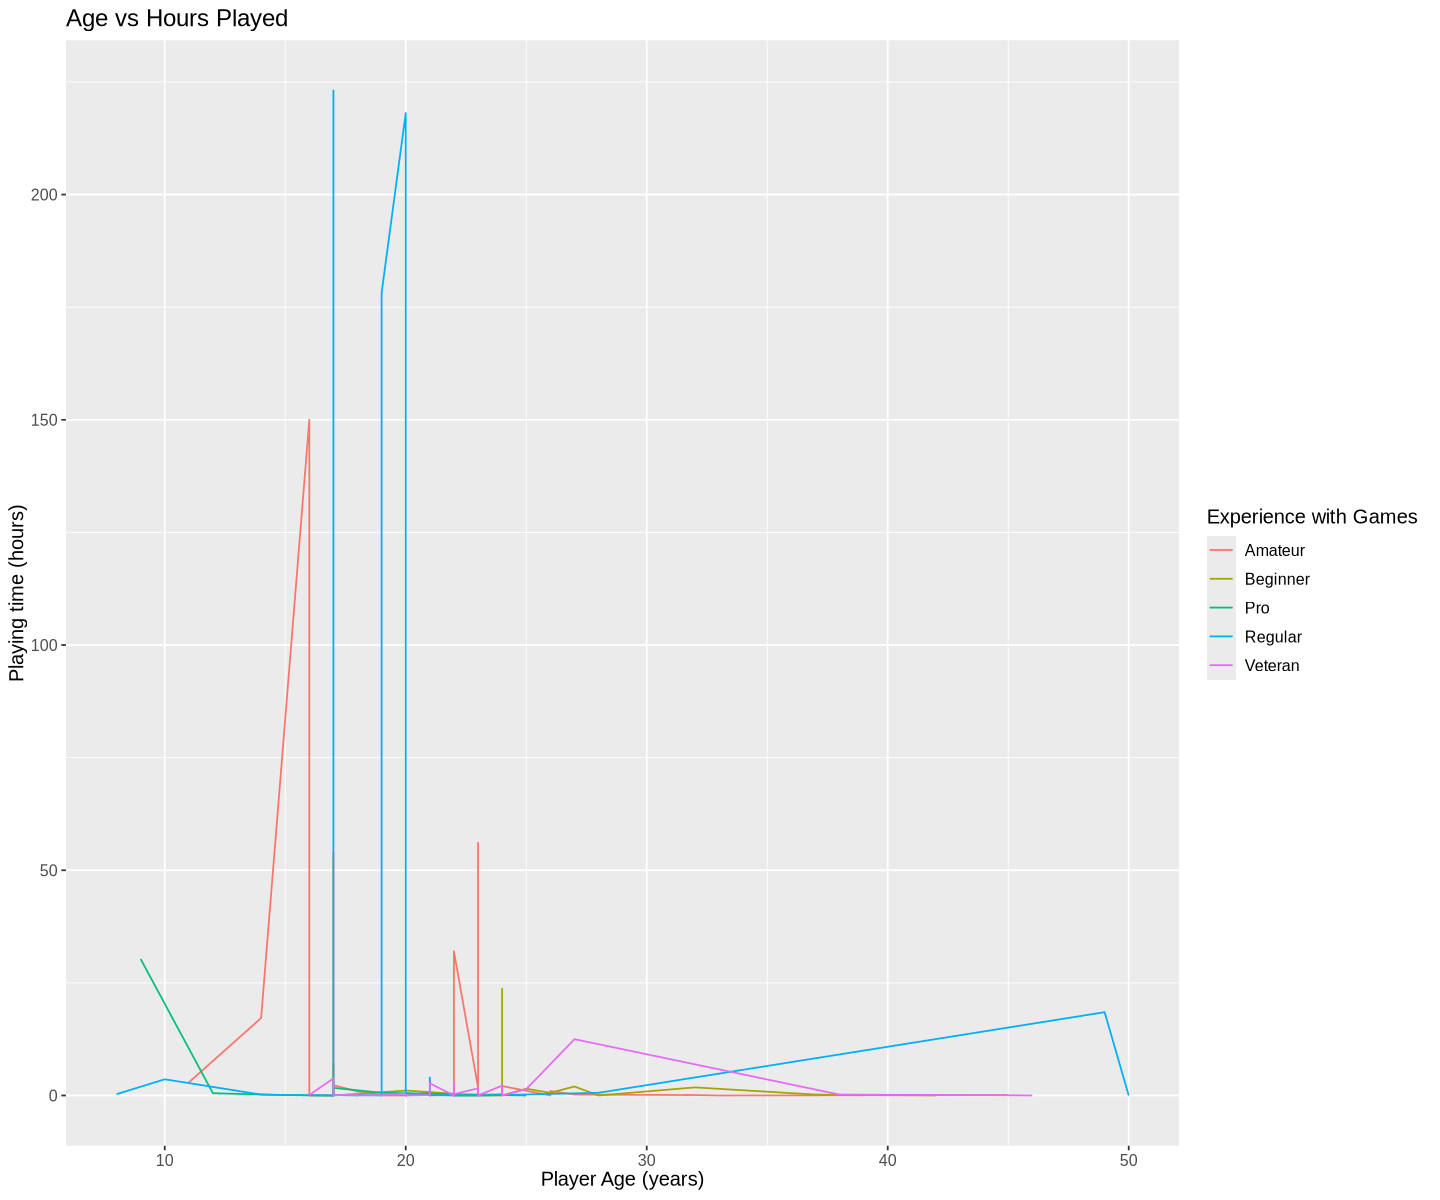

In [10]:
# Preliminary visualization 1: Line plot to observe whether there is a relationship between age and played_hours, coloured by experience.

options(repr.plot.height = 10, repr.plot.width = 12)

hours_vs_age_and_experience <- players |> ggplot(aes(x = Age, y = played_hours, colour = experience)) +
                           geom_line() +
                           labs(title = "Age vs Hours Played" ,x = "Player Age (years)", y = "Playing time (hours)", colour = "Experience with Games") +
                           theme(text = element_text(size =12))
hours_vs_age_and_experience



## Analysis of Preliminary Visualization

This plot yields an interesting and unexpected insight into our dataset, the ones with the most played_hours are of amateur or regular experience with games. In regards to age, those between the range of 15-20 posess the highest hours in conjunction with mostly amateur or regular players in that age group. Veterans in this range have lower hours but veterans of the age range 20-40 have low but noticeable played_hours and more than younger veteran gamers. This may be because the game mainly appeals to regular or amateur gamers but may still prove too difficult or confusing for beginners and too easy for veteran and pro gamers.

This may mean that for recruiting efforts, amateur and regular experienced gamers should be targeted as they contribute most to plaicraft, and hopefully through regression we will be able to succesfully predict those with higher played_hours based on both age and experience based on the insights gained from the preliminary visualization

### Creating Training and Testing Data Splits

Prior to beginning our analysis and creating our regression model, the data must first be split into training and testing splits, for our dataset we will utilize a 65-35 train-test split.

In [11]:
# Assigning split to object player_split, with prop = 0.65 and strata = played_hours

players_split <- players |> initial_split(prop = 0.65, strata = played_hours)

players_train <- training(players_split)

players_test <- testing(players_split)

players_split
# Using head() on training and testing split to observe the data being used for the respective tasks.
head(players_train)
head(players_test)


<Training/Testing/Total>
<125/69/194>

Age,experience,played_hours
<dbl>,<fct>,<dbl>
17,Veteran,0.0
17,Amateur,0.0
19,Regular,0.0
17,Amateur,0.1
22,Veteran,0.0
17,Pro,0.0


Age,experience,played_hours
<dbl>,<fct>,<dbl>
17,Veteran,3.8
21,Regular,0.1
21,Amateur,0.0
17,Veteran,0.0
17,Amateur,0.5
17,Beginner,1.0


## Creating a PairPlot

While we did observe the relationships between variables in the preliminary visualization, it will be useful to create a visualization that is based on the utilized traning data to observe whether the relationship holds and correlations between variables, and to achieve this a pairplot using ggpairs() will be plotted.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


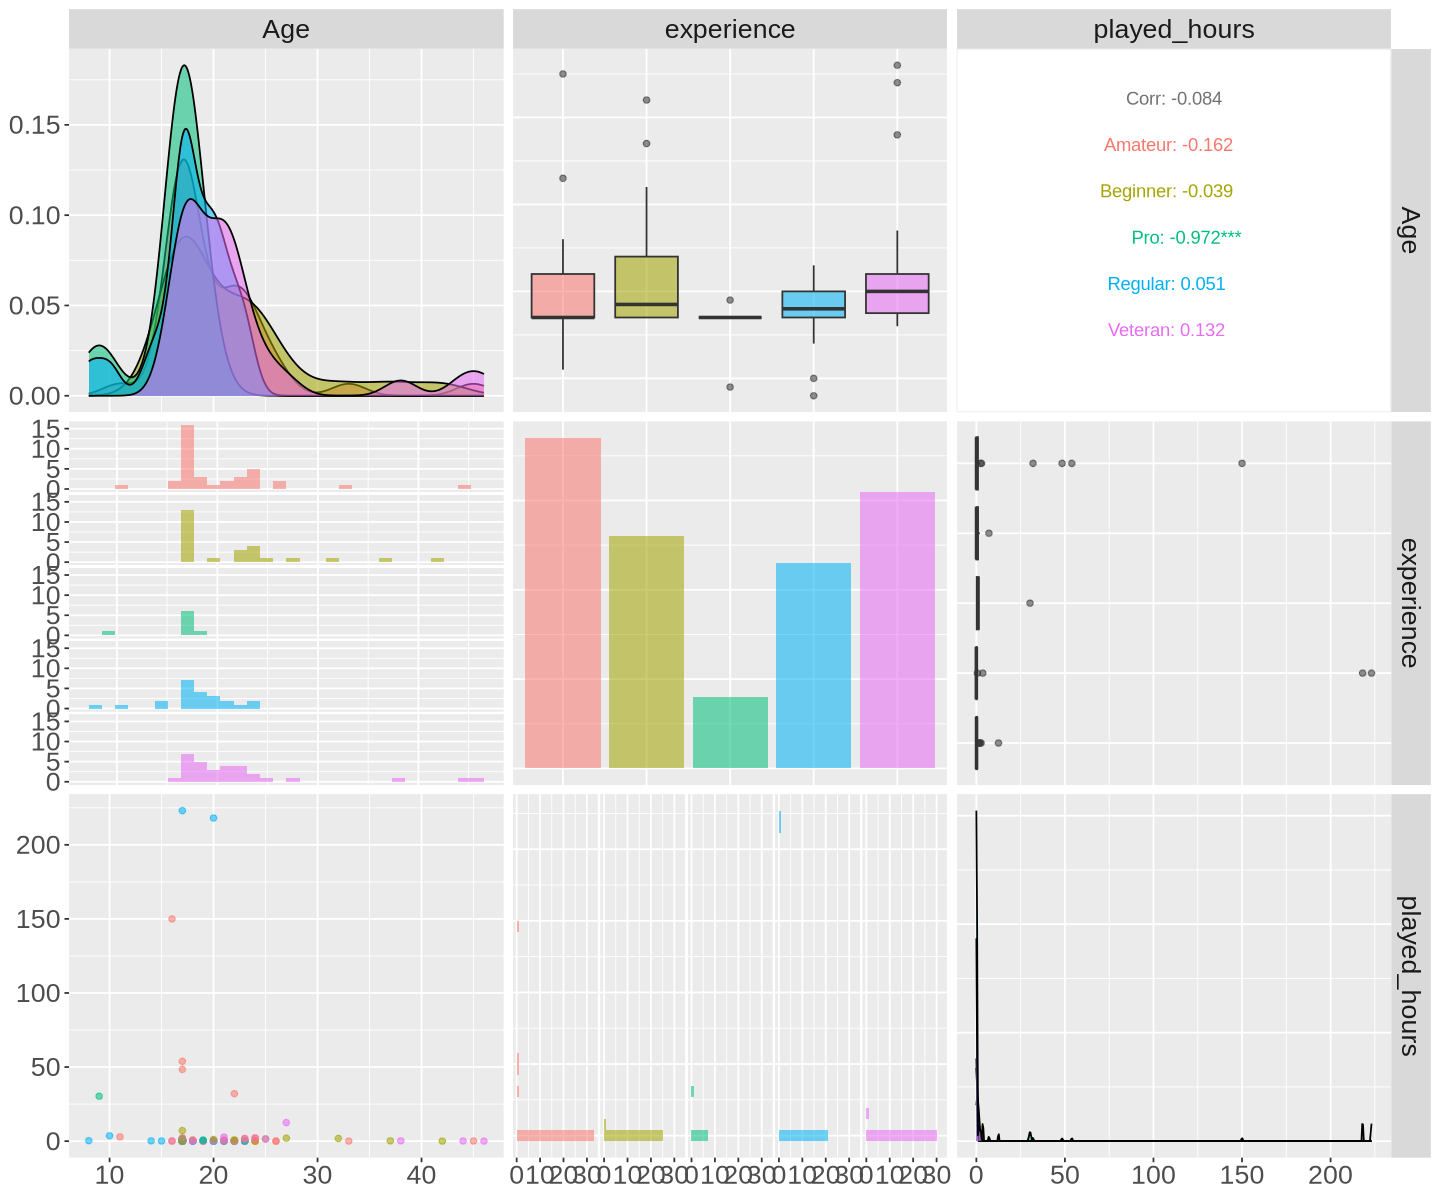

In [12]:
players_pairplot <- players_train |>
ggpairs(mapping = aes(alpha = 0.4, colour = experience)) +
theme(text = element_text(size = 20))

players_pairplot

## Discussion of Which Model to Use

When observing both our preliminary visualization and our pairplot, it is clear that the relationship between Age and played_hours is non-linear. The given correlation values on the pairplot suggests a significant non-linear relationship with the exception of the correlation value for experience == "Pro", where it posesses a value of -0.972 suggesting a negative linear relationship between Age and played_hours for players of that experience status. However, due to the significantly low correlation values of the other experience types, using a linear regression model would not be suitable for this problem, due to the assumptions of a linear relationship that comes with that model.

Instead, due to the non-linear nature of the relationship between Age and played_hours; it is suitable to use a knn regression model for our analysis and therefore it will be utilized to address the problem statement of this project. 

## Creating Model

In [ ]:
## .....